# Machine Learning - Final Assignment
Submitted by: Arushi Makraria

### Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from collections import Counter
import plotly.graph_objects as go
from wordcloud import WordCloud
from tqdm.notebook import tqdm



### Loading Images and Captions

In [2]:
img_path = '/kaggle/input/flickr8k/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [3]:
len(images)

8091

In [4]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [5]:
len(captions)

40457

### Exploratory Data Analysis and Visualization

The segment deals with pre-processing and visualizing the data along with basic EDA.

In [6]:
images_directory = '/kaggle/input/flickr8k/Images/'
# Path to the captions
captions_path = '/kaggle/input/flickr8k/captions.txt'

In [7]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

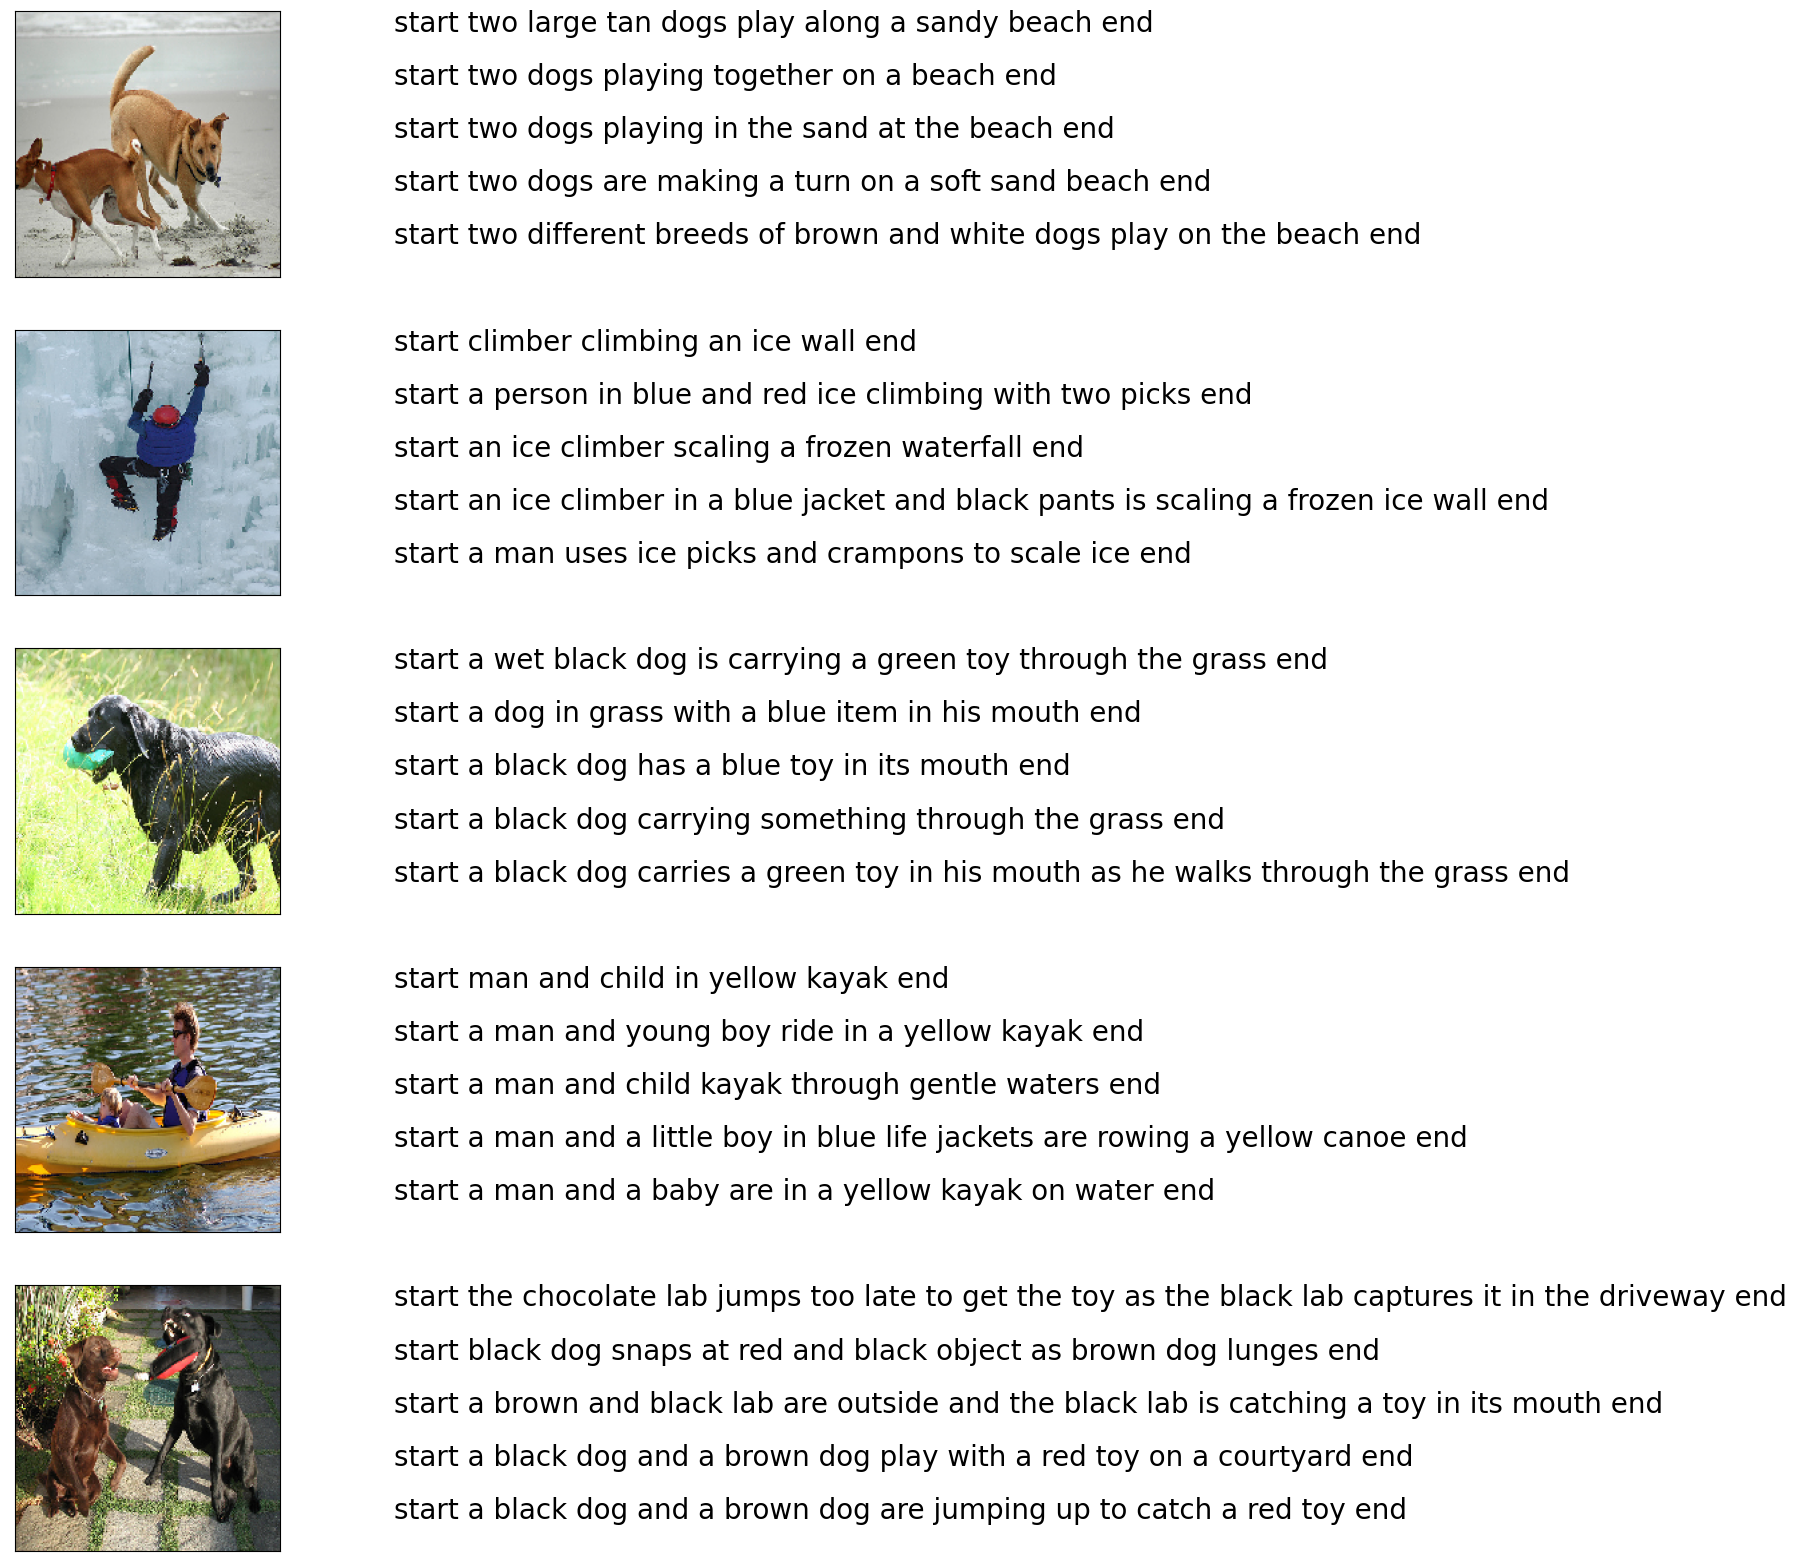

In [8]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

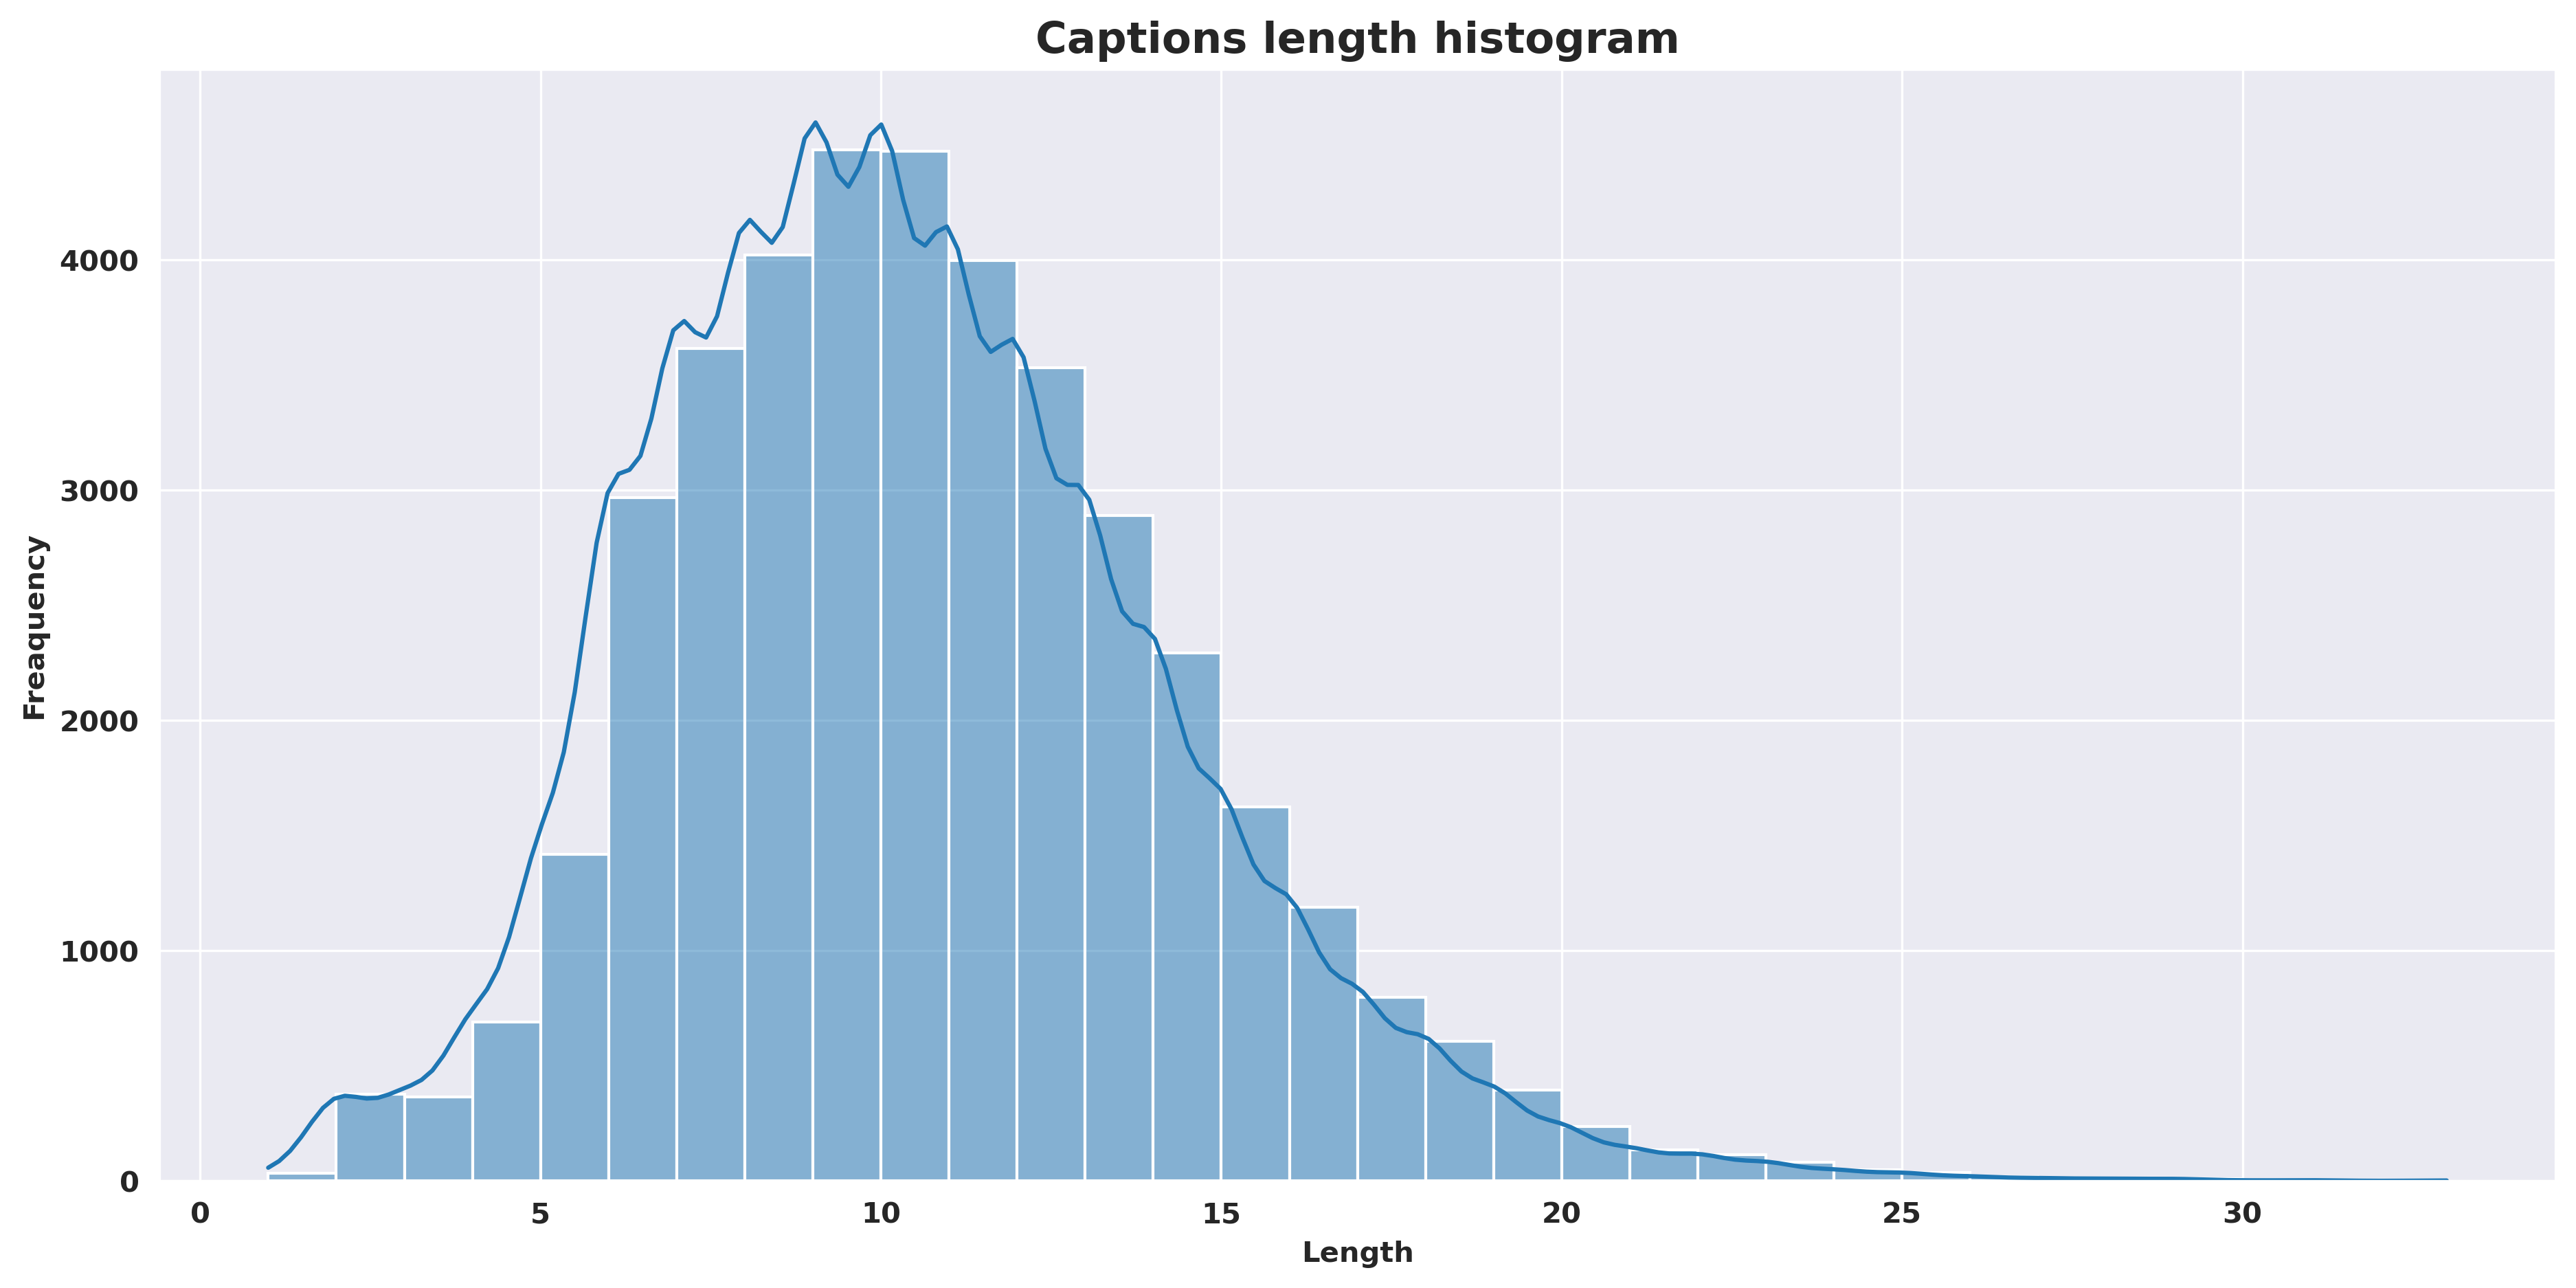

In [9]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

In [10]:
# Create DataFrame with only caption column
caption_data = [caption.split('\t') for caption in captions if len(caption) > 0]

captions_df = pd.DataFrame(caption_data, columns=['caption'])

# Remove leading/trailing whitespaces from captions
captions_df['caption'] = captions_df['caption'].apply(lambda x: x.strip())

# Add an image ID column based on the image filenames
captions_df['image'] = captions_df.index + 1  # Assuming the filenames are indexed starting from 1

# Add a column for caption lengths
captions_df['caption_length'] = captions_df['caption'].apply(lambda x: len(x.split()))

# Display the first few rows of the DataFrame
print(captions_df.head())


                                             caption  image  caption_length
0  1000268201_693b08cb0e.jpg,a child in a pink dr...      1              18
1  1000268201_693b08cb0e.jpg,a girl going into a ...      2               8
2  1000268201_693b08cb0e.jpg,a little girl climbi...      3               9
3  1000268201_693b08cb0e.jpg,a little girl climbi...      4              10
4  1000268201_693b08cb0e.jpg,a little girl in a p...      5              13


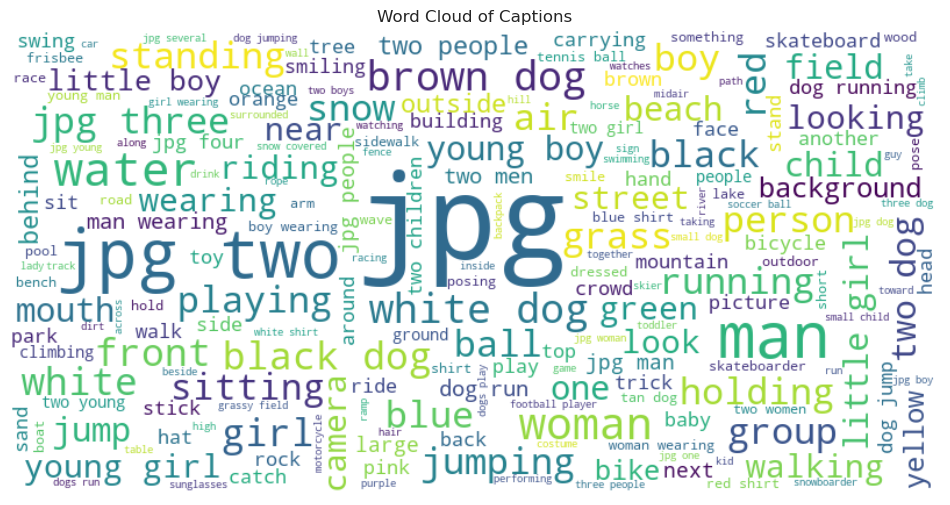

In [11]:
all_captions = ' '.join(captions_df['caption'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_captions)

# Plot word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Captions')
plt.axis('off')
plt.show()

In [12]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[1:15]
    values = list(word_counts.values())[1:15]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions', title_font=dict(size=23, family='Balto'))

    fig.show()

word_occurrences(cleaned_captions)

Loading Image Resolutions:   0%|          | 0/8091 [00:00<?, ?it/s]

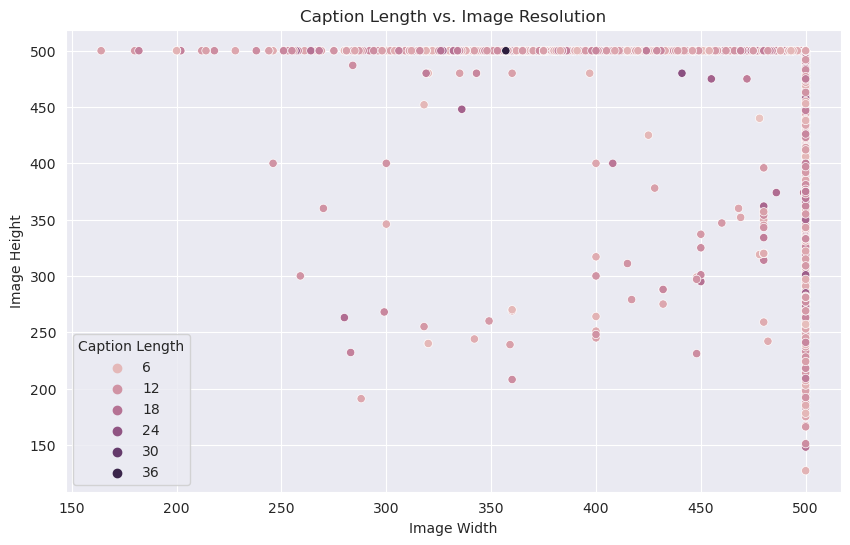

In [13]:
image_resolutions = {}
for img_path in tqdm(images, desc="Loading Image Resolutions"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_resolutions[img_path] = img.shape[:2]
    
image_resolutions_df = pd.DataFrame.from_dict(image_resolutions, orient='index', columns=['height', 'width'])
image_resolutions_df.reset_index(inplace=True)
image_resolutions_df.rename(columns={'index': 'image'}, inplace=True)


# Merge image resolutions with caption DataFrame
merged_df = pd.merge(captions_df, image_resolutions_df, left_on='image', right_index=True)

# Plot caption length vs. image resolution
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='width', y='height', hue='caption_length')
plt.title("Caption Length vs. Image Resolution")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.legend(title="Caption Length")
plt.show()


### Using the RESNET50 Model

In [14]:
inception_model = ResNet50(include_top=True)
#inception_model.summary()

102967424/102967424 [==============================] - 1s 0us/step


### Output of the penultimate layer of RESNET model 

In [15]:
last = inception_model.layers[-2].output 
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Image Feature Extraction 

Notes - Resnet requires the dimnsions to be (224,224,3) and my code is fetching the features of only 1500 images because after experimentation I noted that increasing this leads to memory overload issues and results in crashed kernels. 

In [16]:
# img_features = {}
# count = 0

# for img_path in tqdm(images):
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img,(224,224)) 
#     img = img.reshape(1,224,224,3) 
#     features = model.predict(img).reshape(2048,)
#     img_name = img_path.split('/')[-1]
#     img_features[img_name] = features
#     count += 1
#     if count == 1500:
#         break
#     if count % 50 == 0:
#         print(count)


img_features = {}
count = 0

for img_path in tqdm(images, leave=False):  # Set leave=False to suppress output
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    features = model.predict(img).reshape(2048,)
    img_name = img_path.split('/')[-1]
    img_features[img_name] = features
    count += 1
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
50
1/1 [==============================] - 0s 33ms/step
100
1/1 [==============================] - 0s 33ms/step
150
1/1 [==============================] - 0s 33ms/step
200
1/1 [==============================] - 0s 32ms/step
250
1/1 [==============================] - 0s 32ms/step
300
1/1 [==============================] - 0s 33ms/step
350
1/1 [==============================] - 0s 32ms/step
400
1/1 [==============================] - 0s 32ms/step
450
1/1 [==============================] - 0s 32ms/step
500
1/1 [==============================] - 0s 32ms/step
550
1/1 [==============================] - 0s 32ms/step
600
1/1 [==============================] - 0s 31ms/step
650
1/1 [==============================] - 0s 31ms/step
700
1/1 [==============================] - 0s 32ms/step
750
1/1 [==============================] - 0s 31ms/step
800
1/1 [==============================] - 0s 33ms/step
850
1/1 [==============================] - 0s 33ms/st

In [17]:
len(img_features)

1500

### Extracting captions

In [18]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting\n']

In [19]:
captions[8].split(',')[1]

'two dogs on pavement moving toward each other .\n'

In [20]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

In [21]:
len(captions_dict)

1500

In [22]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [23]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

## Creating vocabulary of the entire text corpus

In [24]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [25]:
len(count_words) # Vocab size

4031

In [26]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [27]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [28]:
max_len

34

In [29]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

4031

### Crafting a custom generator function to yield input image features along with existing text and the text to be generated as output

In [30]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) 
                input_seq = [item[:i]]
                output_seq = item[i] 
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [31]:
X, y_in, y_out = generator(img_features,captions_dict)

In [32]:
len(X), len(y_in), len(y_out)

(92038, 92038, 92038)

In [33]:
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [34]:
X.shape, y_in.shape, y_out.shape

((92038, 2048), (92038, 34), (92038, 4032))

### Splitting the dataset into training, validation, and test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and remaining (which will be further split into validation and test)
X_train, X_rem, y_in_train, y_in_rem, y_out_train, y_out_rem = train_test_split(X, y_in, y_out, test_size=0.3, random_state=42)

# Splitting the remaining dataset into validation and test sets
X_val, X_test, y_in_val, y_in_test, y_out_val, y_out_test = train_test_split(X_rem, y_in_rem, y_out_rem, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_in_train.shape, y_in_val.shape, y_in_test.shape, y_out_train.shape, y_out_val.shape, y_out_test.shape


### Model Architecture along with Visualization

In [35]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 34, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           516096    
                                                                 
 lstm (LSTM)                 (None, 34, 256)           394240    
                            

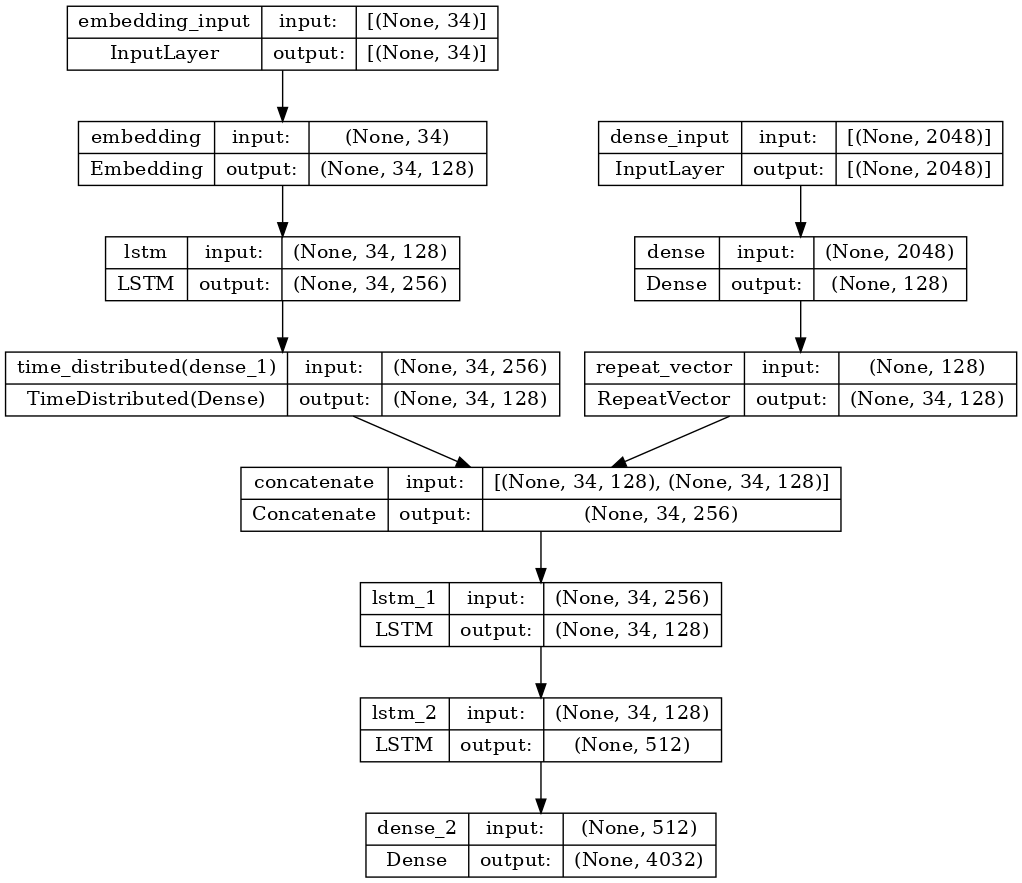

In [36]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

### Training the Model

Epoch 1/200
180/180 [==============================] - ETA: 0s - loss: 5.3427 - accuracy: 0.1147
Epoch 1: accuracy improved from -inf to 0.11475, saving model to image_caption_generator.h5
180/180 [==============================] - 31s 134ms/step - loss: 5.3427 - accuracy: 0.1147
Epoch 2/200
180/180 [==============================] - ETA: 0s - loss: 5.1638 - accuracy: 0.1188
Epoch 2: accuracy improved from 0.11475 to 0.11882, saving model to image_caption_generator.h5
180/180 [==============================] - 17s 93ms/step - loss: 5.1638 - accuracy: 0.1188
Epoch 3/200
180/180 [==============================] - ETA: 0s - loss: 5.0997 - accuracy: 0.1196
Epoch 3: accuracy improved from 0.11882 to 0.11965, saving model to image_caption_generator.h5
180/180 [==============================] - 17s 93ms/step - loss: 5.0997 - accuracy: 0.1196
Epoch 4/200
180/180 [==============================] - ETA: 0s - loss: 5.0292 - accuracy: 0.1198
Epoch 4: accuracy improved from 0.11965 to 0.11981, savi

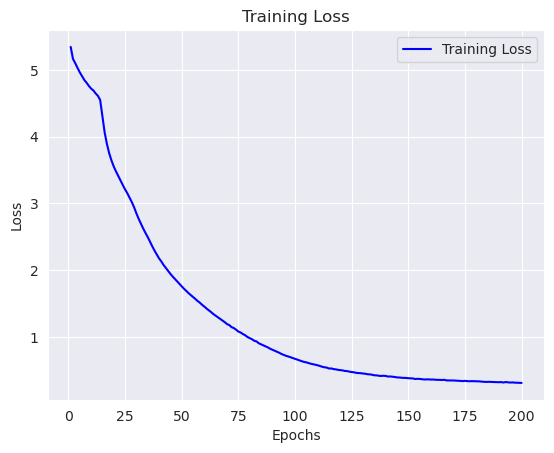

In [37]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

history = final_model.fit([X_train, y_in_train],
                y_out_train,
                validation_data=([X_val, y_in_val], y_out_val),
                batch_size=512,
                callbacks=[mc, es],
                epochs=200)

#training_loss = history.history['loss']

training_loss = history.history['loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

### Saving Final Model and Vocab

In [40]:
final_model.save('image_caption_generator.h5')

In [41]:
np.save('vocab.npy',count_words)

### Sample Predictions

In [42]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

Generating captions:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


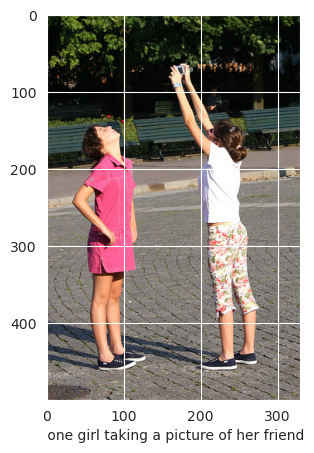

1/1 [==============================] - 0s 33ms/step


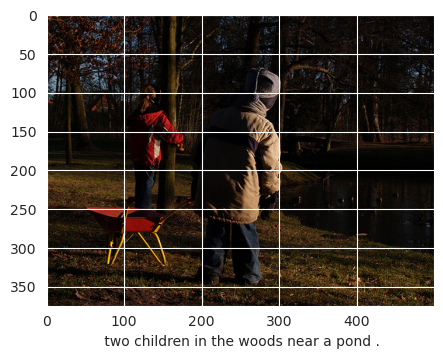

1/1 [==============================] - 0s 32ms/step


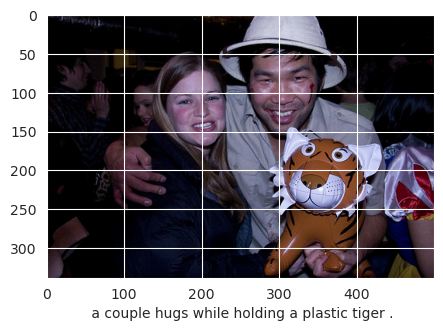

1/1 [==============================] - 0s 29ms/step


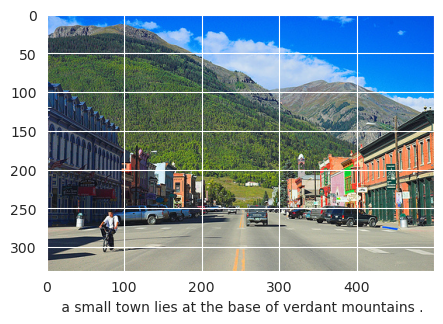

1/1 [==============================] - 0s 26ms/step


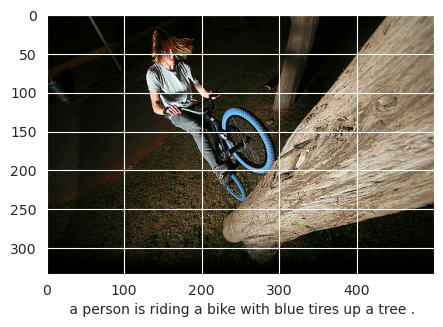

1/1 [==============================] - 0s 28ms/step


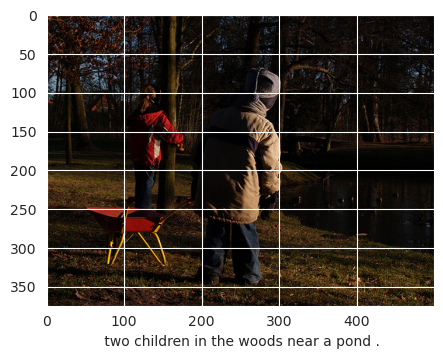

1/1 [==============================] - 0s 29ms/step


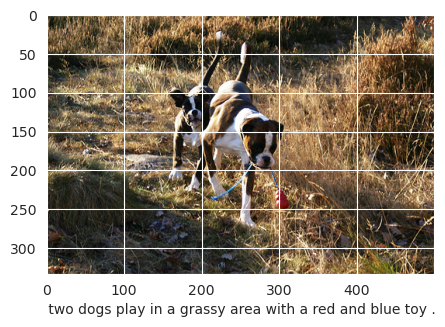

1/1 [==============================] - 0s 26ms/step


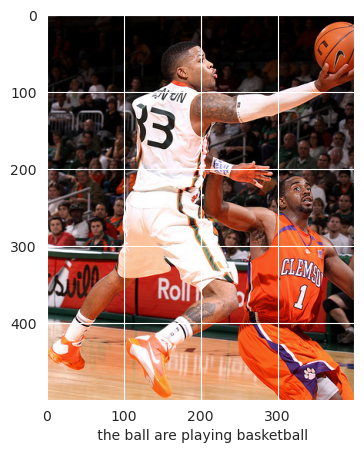

1/1 [==============================] - 0s 35ms/step


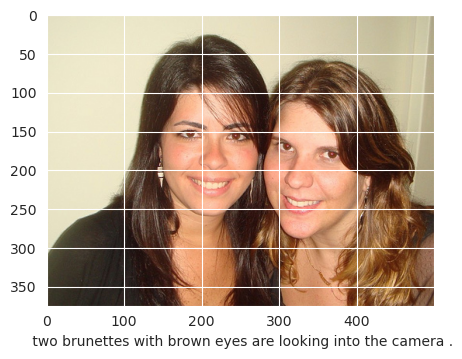

1/1 [==============================] - 0s 28ms/step


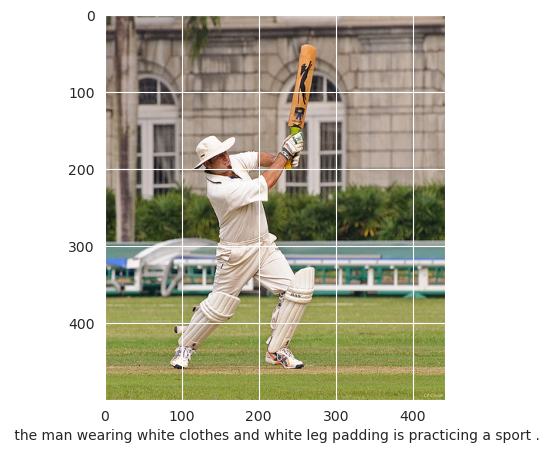

In [44]:
for _ in tqdm(range(10), desc='Generating captions'):
    random_no = np.random.randint(0, 1501)
    test_feature = model.predict(getImage(random_no), verbose=False).reshape(1, 2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = ''  # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        for i in pred_text:
            encoded.append(count_words[i])
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded, maxlen=MAX_LEN, padding='post', truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature, encoded]))  # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx]  # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    # Plot image with caption
    plt.figure(figsize=(5, 5))
    plt.imshow(test_img)
    plt.xlabel(caption)
    plt.show()

THe generated captions are very good at describing what the image is about and our model also has an accuracy of 89%.